# Imports & Configuration

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Literal
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

# Read input data

Считаем данные по одной из метрик

In [14]:
metric_id = "317694"
data = pd.read_csv("../../.data/метрики_торгового_эквайринга.csv", usecols=["datetime", "317694"], parse_dates=["datetime"]) \
         .rename(columns={metric_id: "value"})

print(data.shape)
display(data.head())

(1725120, 2)


,datetime,value
0,2020-01-01 00:00:00,0.0
1,2020-01-01 00:01:00,0.0
2,2020-01-01 00:02:00,0.0
3,2020-01-01 00:03:00,0.0
4,2020-01-01 00:04:00,0.0


In [15]:
data.dtypes

datetime    datetime64[ns]
value              float64
dtype: object

In [16]:
data.isna().sum()

datetime       0
value       6728
dtype: int64

Заполним пропуски

In [18]:
data.loc[:, "value"] = data.loc[:, "value"].interpolate(method="linear", limit_area="inside")

Выберем промежуток времени, на котором будем "рисовать" тренд

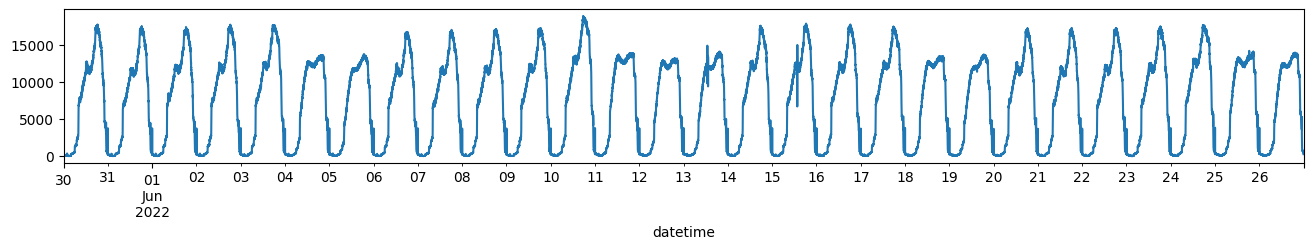

In [81]:
datetime_from, datetime_to = "2022-05-30 00:00:00", "2022-06-26 23:59:00"
filtered_data = data.loc[
    (data["datetime"] >= datetime_from) & (data["datetime"] <= datetime_to), :
    ].reset_index(drop=True, inplace=False)
filtered_data.set_index("datetime").plot(figsize=(16, 2), legend=None);

# Trend detection

Подход к детекции тренда взят из [статьи](https://towardsdatascience.com/removing-non-linear-trends-from-timeseries-data-b21f7567ed51)

## Linear trend

In [82]:
x = np.reshape(filtered_data.index, newshape=(-1, 1))
y = filtered_data["value"].values

lr = LinearRegression()
lr.fit(x, y)
linear_trend_data = filtered_data
linear_trend_data["trend"] = lr.predict(x)
linear_trend_data["detrended"] = linear_trend_data["value"] - linear_trend_data["trend"]

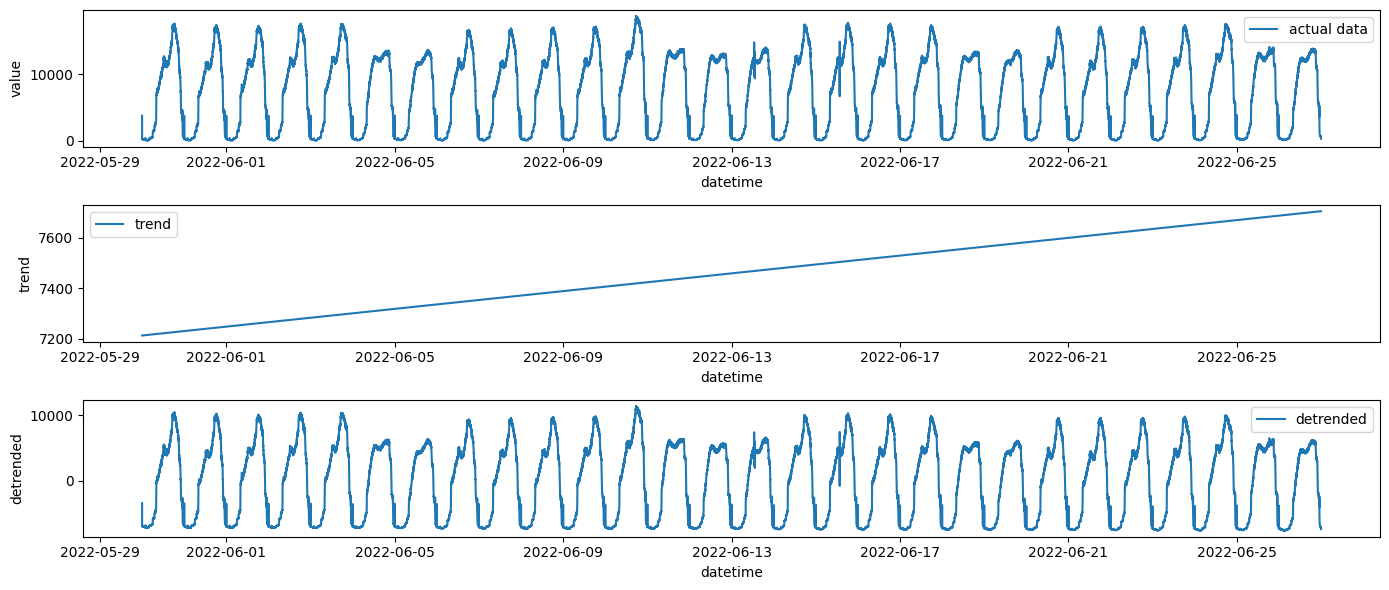

In [83]:
fig, (ax_value, ax_trend, ax_detrended) = plt.subplots(nrows=3, ncols=1, figsize=(14, 2*3))
sns.lineplot(data=linear_trend_data, x="datetime", y="value", ax=ax_value, label="actual data")
sns.lineplot(data=linear_trend_data, x="datetime", y="trend", ax=ax_trend, label="trend")
sns.lineplot(data=linear_trend_data, x="datetime", y="detrended", ax=ax_detrended, label="detrended")
fig.tight_layout();

## Polynomial trend

Пример

In [80]:
x = np.array([
    [1, 2],
    [4, 2],
    [6, 3]
])

print("Полиномиальные фичи 2-ой степени")

pf = PolynomialFeatures(degree=2, include_bias=False)
xp = pf.fit_transform(x)
display(pd.DataFrame(data=xp, columns=pf.get_feature_names_out()))

print("\n")
print("Полиномиальные фичи 3-ей степени")

pf = PolynomialFeatures(degree=3, include_bias=False)
xp = pf.fit_transform(x)
display(pd.DataFrame(data=xp, columns=pf.get_feature_names_out()))

Полиномиальные фичи 2-ой степени


,x0,x1,x0^2,x0 x1,x1^2
0,1.0,2.0,1.0,2.0,4.0
1,4.0,2.0,16.0,8.0,4.0
2,6.0,3.0,36.0,18.0,9.0




Полиномиальные фичи 3-ей степени


,x0,x1,x0^2,x0 x1,x1^2,x0^3,x0^2 x1,x0 x1^2,x1^3
0,1.0,2.0,1.0,2.0,4.0,1.0,2.0,4.0,8.0
1,4.0,2.0,16.0,8.0,4.0,64.0,32.0,16.0,8.0
2,6.0,3.0,36.0,18.0,9.0,216.0,108.0,54.0,27.0


Переходим к нашему временному ряду

In [84]:
x = np.reshape(filtered_data.index, newshape=(-1, 1))
pf = PolynomialFeatures(degree=2, include_bias=False)
xp = pf.fit_transform(x)
y = filtered_data["value"].values

In [91]:
lr = LinearRegression()
lr.fit(xp, y)
polynomial_trend_data = filtered_data
polynomial_trend_data["trend"] = lr.predict(xp)
polynomial_trend_data["detrended"] = polynomial_trend_data["value"] - polynomial_trend_data["trend"]

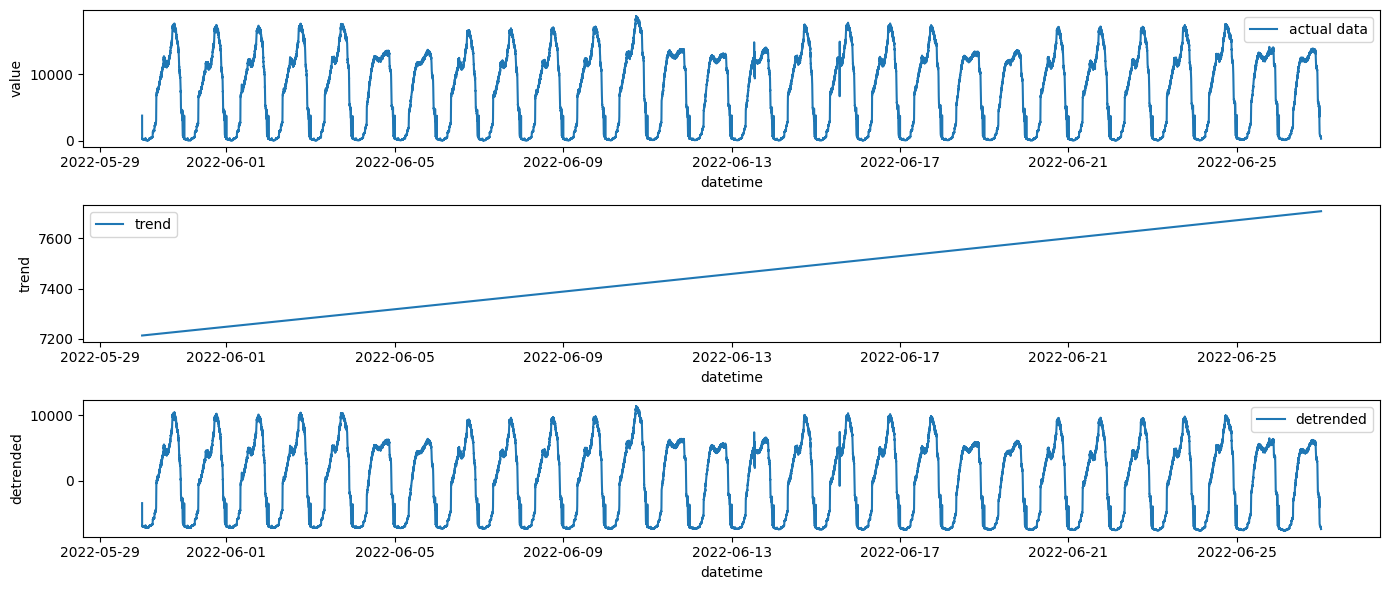

In [92]:
fig, (ax_value, ax_trend, ax_detrended) = plt.subplots(nrows=3, ncols=1, figsize=(14, 2*3))
sns.lineplot(data=polynomial_trend_data, x="datetime", y="value", ax=ax_value, label="actual data")
sns.lineplot(data=polynomial_trend_data, x="datetime", y="trend", ax=ax_trend, label="trend")
sns.lineplot(data=polynomial_trend_data, x="datetime", y="detrended", ax=ax_detrended, label="detrended")
fig.tight_layout();